In [17]:
import re
import sys
from data.scraping import googleScraping
import urllib.request, urllib.error
from urllib.error import HTTPError
from cabocha.analyzer import CaboChaAnalyzer
from cabocha.analyzer import EndOfLinkException 
from datetime import datetime
import pandas as pd
from enum import Enum
from datetime import datetime
import numpy as np
import uuid
import collections
import asyncio
import tornado.ioloop
from tornado.iostream import IOStream

class Crawler:
    def __init__(self):
        self.uid = str(uuid.uuid4())
        self.keyword = ""
        self.url = ""
        self.article = ""
        self.causals = []
        self.createdAt = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        self.updatedAt = datetime.now().strftime("%Y/%m/%d %H:%M:%S")


class Relation(Enum):
    cause = 0
    goal = 1
    equal = 2
    specific = 3
    abstract = 4

    def toJson(self):
        if self == Relation.cause:
            return "cause"
        elif self == Relation.goal:
            return "goal"
        elif self == Relation.equal:
            return "equal"
        elif self == Relation.specific:
            return "specific"
        elif self == Relation.abstract:
            return "abstract"
        
    def toJaKeyword(self):
        if self == Relation.cause:
            return "なぜ"
        elif self == Relation.goal:
            return "どうやって"
        elif self == Relation.equal:
            return "とは"
        elif self == Relation.specific:
            return ""
        elif self == Relation.abstract:
            return ""


class Pattern(Enum):
    A = 0
    B = 1
    C = 2
    D = 3
    E = 4

    def toJson(self):
        if self == Pattern.A:
            return "A"
        elif self == Pattern.B:
            return "B"
        elif self == Pattern.C:
            return "C"
        elif self == Pattern.D:
            return "D"
        elif self == Pattern.E:
            return "E"

    def toOneHot(self):
        zeros = np.zeros(5)
        if self == Pattern.A:
            zeros[0] = 1
            return zeros
        elif self == Pattern.B:
            zeros[1] = 1
            return zeros
        elif self == Pattern.C:
            zeros[2] = 1
            return zeros
        elif self == Pattern.D:
            zeros[3] = 1
            return zeros
        elif self == Pattern.E:
            zeros[4] = 1
            return zeros

class Causal:
    def __init__(self):
        self.uid = str(uuid.uuid4())
        self.basis = ""
        self.result = ""
        self.subj = ""
        self.pattern = ""
        self.clue = ""
        self.filePath = ""
        self.line = 0
        self.causalId = 0
        self.sentence = ""
        self.relation = Relation.cause
        self.createdAt = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        self.updatedAt = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

    # def __init__(self):

    # def __init__(self,basis,result,subj,pattern):
    #     self.basis = basis
    #     self.result = result
    #     self.subj = subj
    #     self.pattern = pattern

    def toJson(self):
        json = "{"
        json += "\"clue\": " + "\"" + self.clue + "\", "
        json += "\"basis\": " + "\"" + self.basis + "\", "
        json += "\"result\": " + "\"" + self.result + "\", "
        json += "\"subj\": " + "\"" + self.subj + "\", "
        json += "\"pattern\": " + "\"" + self.pattern + "\", "
        json += "\"filePath\": " + "\"" + self.filePath + "\", "
        json += "\"line\": " + self.line
        json += "}"
        return json

    def noneCheck(self):
        return all([self.basis != "", self.result != "", self.clue != "", self.sentence != "", self.basis != None,
                    self.result != None, self.clue != None, self.sentence != None])

class ResultExpression:
    def __init__(self):
        self.uid = str(uuid.uuid4())
        self.result = ""
        self.pos = ""
        self.pos1 = ""
        self.causal = Causal()
        self.relation = Relation.cause
        self.createdAt = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        self.updatedAt = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

class ClueExpression:
    def __init__(self):
        self.uid = str(uuid.uuid4())
        self.clue = ""
        self.pos = ""
        self.pos1 = ""
        self.basis_pos = ""
        self.basis_pos1 = ""
        self.causal = Causal()
        self.relation = Relation.cause
        self.createdAt = datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        self.updatedAt = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

class Goal:
    def __init__(self):
        self.uid = str(uuid.uuid4())
        self.text                    = ""
        self.credit                  = 0
        self.smart                   = Smart()
        self.steps                   = []
        self.owner                   = PrunedUser()
        self.private                 = False
        self.createdAt               = ""
        self.updatedAt               = ""

class Step:
    def __init__(self):
        self.uid = str(uuid.uuid4())
        self.text                    = ""
        self.credit                  = 0
        self.smart                   = Smart()
        # self.tasks                   = []
        self.owner                   = PrunedUser()
        self.private                 = False
        self.createdAt               = ""
        self.updatedAt               = ""

class Smart:
    def __init__(self):
        self.uid = str(uuid.uuid4())
        self.specificSubject         = ""
        self.specificVerb            = ""
        self.timeBound               = ""
        self.measurable              = ""
        self.credit                  = 0
        self.owner                   = PrunedUser()
        self.private                 = False
        self.createdAt               = ""
        self.updatedAt               = ""

    def getJaText(self):
        return self.specificSubject + self.timeBound + self.measurable + self.specificVerb

class PrunedUser:
    def __init__(self):
        self.uid = str(uuid.uuid4())
        self.credit                  = 0
        self.sumCredit               = 0
        self.displayName             = ""
        self.profileImage            = ""
        self.backgroundImage         = ""
        self.registrationConfirmed   = ""
        self.permissions             = False
        self.private                 = False
        self.createdAt               = ""
        self.updatedAt               = ""

In [18]:
import math
import numpy
import collections

class causal_rank:
    def lex_rank(self, sentences, n=0, t=0.1):
        if sentences == None or sentences == []:
            return []
        n =  len(sentences) if n==0 else n
        """
        LexRankで文章を要約する．
        @param  sentences: list
            文章([[w1,w2,w3],[w1,w3,w4,w5],..]のような文リスト)
        @param  n: int
            文章に含まれる文の数
        @param  t: float
            コサイン類似度の閾値(default 0.1)
        @return : list
            LexRank
        """
        cosine_matrix = numpy.zeros((n, n))
        degrees = numpy.zeros((n,))
        l = []

         # 1. 隣接行列の作成
        for i in range(n):
            for j in range(n):
                cosine_matrix[i][j] = self.idf_modified_cosine(sentences, sentences[i], sentences[j])
                if cosine_matrix[i][j] > t:
                    cosine_matrix[i][j] = 1
                    degrees[i] += 1
                else:
                    cosine_matrix[i][j] = 0

        # 2.LexRank計算
        for i in range(n):
            for j in range(n):
                cosine_matrix[i][j] = cosine_matrix[i][j] / degrees[i]

        ratings = self.power_method(cosine_matrix, n)
        print(sentences, ratings)
        return zip(sentences, ratings)
    
    def idf_modified_cosine(self, sentences, sentence1, sentence2):
        """
        2文間のコサイン類似度を計算
        @param  sentence1: list
            文1([w1,w2,w3]のような単語リスト)
        @param  sentence2: list
            文2([w1,w2,w3]のような単語リスト)
        @param  sentences: list
            文章([[w1,w2,w3],[w1,w3,w4,w5],..]のような単語リスト)
        @return : float
            コサイン類似度
        """
        tf1 = self.compute_tf(sentence1)
        tf2 = self.compute_tf(sentence2)
        idf_metrics = self.compute_idf(sentences)
        return self.cosine_similarity(sentence1, sentence2, tf1, tf2, idf_metrics)


    def compute_tf(self, sentence):
        """
        TFを計算
        @param  sentence: list
            文([w1,w2,w3]のような単語リスト)
        @return : list
            TFリスト
        """
        tf_values = collections.Counter(sentence)
        tf_metrics = {}

        max_tf = self.find_tf_max(tf_values)

        for term, tf in tf_values.items():
            tf_metrics[term] = tf / max_tf

        return tf_metrics


    def find_tf_max(self, terms):
        """
        単語の最大出現頻度を探索
        @param  terms: list
            単語の出現頻度
        @return : int
            単語の最大出現頻度
        """
        return max(terms.values()) if terms else 1


    def compute_idf(self, sentences):
        """
        文章中の単語のIDF値を計算
        @param sentences: list
            文章([[w1,w2,w3],[w1,w3,w4,w5],..]のような単語リスト)
        @return: list
            IDFリスト
        """
        idf_metrics = {}
        sentences_count = len(sentences)

        for sentence in sentences:
            for term in sentence:
                if term not in idf_metrics:
                    n_j = sum(1 for s in sentences if term in s)
                    idf_metrics[term] = math.log(sentences_count / (1 + n_j))

        return idf_metrics


    def cosine_similarity(self, sentence1, sentence2, tf1, tf2, idf_metrics):
        """
        コサイン類似度を計算
        @param  sentence1: list
            文1([w1,w2,w3]のような単語リスト)
        @param  sentence2: list
            文2([w1,w2,w3]のような単語リスト)
        @param  tf1: list
            文1のTFリスト
        @param  tf2: list
            文2のTFリスト
        @param  idf_metrics: list
            文章のIDFリスト
        @return : float
            コサイン類似度
        """
        unique_words1 = set(sentence1)
        unique_words2 = set(sentence2)
        common_words = unique_words1 & unique_words2

        numerator = sum((tf1[t] * tf2[t] * idf_metrics[t] ** 2) for t in common_words)
        denominator1 = sum((tf1[t] * idf_metrics[t]) ** 2 for t in unique_words1)
        denominator2 = sum((tf2[t] * idf_metrics[t]) ** 2 for t in unique_words2)

        if denominator1 > 0 and denominator2 > 0:
            return numerator / (math.sqrt(denominator1) * math.sqrt(denominator2))
        else:
            return 0.0    
        
    def power_method(self, cosine_matrix, n, e=0.1):
        """
        べき乗法を行なう
        @param  scosine_matrix: list
            確率行列
        @param  n: int
            文章中の文の数
        @param  e: float
            許容誤差ε
        @return: list
            LexRank
        """
        transposed_matrix = cosine_matrix.T
        sentences_count = n

        p_vector = numpy.array([1.0 / sentences_count] * sentences_count)

        lambda_val = 1.0

        while lambda_val > e:
            next_p = numpy.dot(transposed_matrix, p_vector)
            lambda_val = numpy.linalg.norm(numpy.subtract(next_p, p_vector))
            p_vector = next_p

        return p_vector


In [26]:
class extractor:

    pMeasurableKakujosi = re.compile('から$|より$')

    clueList = []

    eclueList = []

    gclueList = []

    geclueList = []

    eqclueList = []

    eqeclueList = []

    demonList = []

    skipList = []

    clueBFilterList = []

    eclueBFilterList = []

    gclueBFilterList = []

    geclueBFilterList = []

    eqclueBFilterList = []

    eqeclueBFilterList = []

    clueRFilterList = []

    eclueRFilterList = []

    gclueRFilterList = []

    geclueRFilterList = []

    eqclueRFilterList = []

    eqeclueRFilterList = []

    cluePosList = []

    gcluePosList = []

    eqcluePosList = []

    cluePos1List = []

    gcluePos1List = []

    eqcluePos1List = []
    
    skipList = []

    @staticmethod
    def getTextFromChunks(tree):
        text = ""
        for chunk in tree:
            text += chunk.surface
        return text

    @staticmethod
    def getTextFromTokens(chunk):
        text = ""
        for token in chunk:
            text += token.surface
        return text
    
    @staticmethod
    def causalUniqueSentence( causals):
        duplicatedIndex = []
        df = pd.DataFrame()
        df['sentence'] = [causal.sentence for causal in causals if causal.noneCheck()]
        df['causal'] = [causal for causal in causals if causal.noneCheck()]
        [duplicatedIndex.append(df[df['sentence'] == causal.sentence].index.tolist()) for causal in causals if causal.noneCheck()]
        for indexes in duplicatedIndex:
            for i, index in enumerate(indexes):
                if i > 0:
                    try:
                        df = df.drop(index, axis=0)
                    except:
                        break
        return [item['causal'] for index, item in df.iterrows()]

    def __init__(self):
        self.utilSet()

    def utilSet(self):
        
        self.skipList = pd.read_csv("Util/ja_skip_list.csv").dropna(subset=['clue'])['clue']
        
        self.clueList = pd.read_csv("Util/ja_clue_list.csv").dropna(subset=['clue'])['clue']
        self.eclueList = pd.read_csv("Util/ja_eclue_list.csv").dropna(subset=['clue'])['clue']
        self.gclueList = pd.read_csv("Util/ja_goal_clue_list.csv").dropna(subset=['clue'])['clue']
        self.geclueList = pd.read_csv("Util/ja_goal_eclue_list.csv").dropna(subset=['clue'])['clue']
        self.eqclueList = pd.read_csv("Util/ja_equal_clue_list.csv").dropna(subset=['clue'])['clue']
        self.eqeclueList = pd.read_csv("Util/ja_equal_eclue_list.csv").dropna(subset=['clue'])['clue']

        self.cluePosList = pd.read_csv("Util/ja_clue_list.csv").dropna(subset=['clue'])["clue_pos"]
        self.gcluePosList = pd.read_csv("Util/ja_goal_clue_list.csv").dropna(subset=['clue'])["clue_pos"]
        self.eqcluePosList = pd.read_csv("Util/ja_equal_clue_list.csv").dropna(subset=['clue'])["clue_pos"]
        self.cluePos1List = pd.read_csv("Util/ja_clue_list.csv").dropna(subset=['clue'])["clue_pos1"]
        self.gcluePos1List = pd.read_csv("Util/ja_goal_clue_list.csv").dropna(subset=['clue'])["clue_pos1"]
        self.eqcluePos1List = pd.read_csv("Util/ja_equal_clue_list.csv").dropna(subset=['clue'])["clue_pos1"]

        self.clueBFilterList = pd.read_csv("Util/ja_clue_list.csv").dropna(subset=['clue'])['basis_pos']
        #         self.eclueBFilterList = pd.read_csv("Util/ja_eclue_list.csv").dropna(subset=['clue'])['basis_pos']
        self.gclueBFilterList = pd.read_csv("Util/ja_goal_clue_list.csv").dropna(subset=['clue'])['basis_pos']
        #         self.geclueBFilterList = pd.read_csv("Util/ja_goal_eclue_list.csv").dropna(subset=['clue'])['basis_pos']
        self.eqclueBFilterList = pd.read_csv("Util/ja_equal_clue_list.csv").dropna(subset=['clue'])['basis_pos']

    #         self.eqeclueBFilterList = pd.read_csv("Util/ja_equal_eclue_list.csv").dropna(subset=['clue'])['basis_pos']

    #         self.clueRFilterList = pd.read_csv("Util/ja_clue_list.csv").dropna(subset=['clue'])['result_pos']
    # #         self.eclueRFilterList = pd.read_csv("Util/ja_eclue_list.csv").dropna(subset=['clue'])['result_pos']
    #         self.gclueRFilterList = pd.read_csv("Util/ja_goal_clue_list.csv").dropna(subset=['clue'])['result_pos']
    # #         self.geclueRFilterList = pd.read_csv("Util/ja_goal_eclue_list.csv").dropna(subset=['clue'])['result_pos']
    #         self.eqclueRFilterList = pd.read_csv("Util/ja_equal_clue_list.csv").dropna(subset=['clue'])['result_pos']
    # #         self.eqeclueRFilterList = pd.read_csv("Util/ja_equal_eclue_list.csv").dropna(subset=['clue'])['result_pos']

    def checkSkip(self, causal, skipList):
        return any([skip in causal.sentence for skip in skipList])

    def checkResult(self, causals):
        [causals.remove(causal) for causal in causals if causal == None]
        reslutCausals = []
        try:
            [[reslutCausals.append(causal2) for causal2 in causals if all(
                [causal1.sentence == causal2.sentence, causal2.clue.pattern == Pattern.A or causal2.clue.pattern == Pattern.B,
                 causal1.clue.pattern == Pattern.C or causal1.clue.pattern == Pattern.D])] for causal1 in causals]
        except AttributeError:
            pass
        return reslutCausals
    
    #todo:以上以下とかもここでやる
    def checkPronoun(self, causal):
        analyzer = CaboChaAnalyzer()
        basis_tree = analyzer.parse(re.sub("、", "",causal.basis))
        for chunk in basis_tree:
            for token in chunk:
                if token.pos == "名詞" and token.pos1  == "代名詞":
                    return True
                elif token.pos == "連体詞" and re.match(r'こ|そ|あ|ど', token.surface):
                    return True
                elif token.pos == "副詞" and token.pos1  == "助詞類接続" and re.match(r'^こ|そ|あ|ど', token.surface):
                    return True
                elif token.surface == "これ" or token.surface == "それ" or token.surface == "あれ" or token.surface == "どれ" or token.surface == "こう" or token.surface == "そう" or token.surface == "そちら" or token.surface == "こちら" or token.surface == "あちら":
                    return True
        return False
    
    def checkCausalSize(self, causal, avarage=14):
        analyzer = CaboChaAnalyzer()
        return any([analyzer.parse(causal.sentence).chunk_size > avarage, analyzer.parse(causal.basis).chunk_size > avarage / 2, analyzer.parse(causal.result).chunk_size > avarage / 2])

    def checkECausalSize(self, causal, avarage=14):
        analyzer = CaboChaAnalyzer()
        return any([analyzer.parse(causal.basis).chunk_size > avarage / 2, analyzer.parse(causal.result).chunk_size > avarage / 2])
    
    def causalUnique(self, causals):
        causals = list(set(causals))
        [causals.remove(causal) for causal in causals if causal == None]
        try:
            [[causals.remove(causal2) for causal2 in causals if
              all([causal1.sentence == causal2.sentence, causal2.clue in causal1.clue, causal2.clue != causal1.clue])]
             for causal1 in causals]
        except AttributeError:
            pass
        return causals

    def causalFilter(self, causals, basis_list, result_list):
        analyzer = CaboChaAnalyzer()
        newCausals = []
        for causal in causals:
            if causal.pattern != Pattern.E:
                tree = analyzer.parse(re.sub("、", "",causal.basis))
                try:
                    chunk = tree[tree.chunk_size - 1] if tree.chunk_size > 0 else tree[0]
                    if any([chunk[chunk.token_size - 1].pos == str(basis_list[causal.causalId]) and str(basis_list[causal.causalId]) != "nan", str(basis_list[causal.causalId]) == "nan"]) and not self.checkPronoun(causal) and not self.checkCausalSize(causal) and tree.chunk_size > 2:# and not re.search(r'www|html|http|jpg|png|jpeg|com', causal.sentence) and not re.search(r'www|html|http|jpg|png|jpeg|com', causal.basis):
                        newCausals.append(causal)
                except IndexError:
                    pass
            if causal.pattern == Pattern.E and not self.checkPronoun(causal) and not self.checkECausalSize(causal):# and not re.search(r'www|html|http|jpg|png|jpeg|com', causal.sentence) and not re.search(r'www|html|http|jpg|png|jpeg|com', causal.basis):
                newCausals.append(causal)
        return newCausals

    def checkCorePos(self, causal, cluePosList, cluePos1List):
        if causal.pattern == Pattern.E:
            return True
        if str(cluePosList[causal.causalId]) == "nan":
            return True
        if str(cluePos1List[causal.causalId]) == "nan":
            clue_pos1 = []
        clue_pos = str(cluePosList[causal.causalId]).split(",")
        clue_pos1 = str(cluePos1List[causal.causalId]).split(",")
        analyzer = CaboChaAnalyzer()
        tree = analyzer.parse(causal.sentence)
        check_token = []
        for chunk in tree:
            if causal.clue in chunk.surface:
                [check_token.append(token) for token in chunk if token.surface in causal.clue]
                if "".join(token.surface for token in check_token) == causal.clue:
                    break
        for index, token in enumerate(check_token):
            if token.pos == clue_pos[index]:
                if clue_pos1 == []:
                    return True
                elif clue_pos1[index] == "" or clue_pos1[index] == None:
                    break
                elif token.pos1 == clue_pos1[index]:
                    return True
                else:
                    return False
            else:
                return False

    def checkKindSentence(self, separateChunks, skipChunk=None):
        subj = ""
        text = ""
        for chunks in separateChunks:
            lastChunk = chunks[len(chunks) - 1]
            lastToken = lastChunk[lastChunk.token_size - 1]
            if skipChunk != None and skipChunk in chunks:
                break
            if lastToken.pos == "記号":
                lastToken = lastChunk[lastChunk.token_size - 2]
            # 逆説
            if lastToken.pos == "助詞" and lastToken.pos1 == "接続助詞" and lastToken.surface == "が":
                separateChunks.remove(chunks)
            # 主節
            elif lastToken.pos == "助詞" and lastToken.pos1 == "格助詞":
                subj = extractor.getTextFromChunks(chunks)
            elif lastToken.pos == "助詞" and lastToken.pos1 == "係助詞" and lastToken.surface == "も":
                separateChunks.remove(chunks)
        #             elif lastToken.pos == "助動詞":
        #                 separateChunks.remove(chunks)
        for chunks in separateChunks:
            text += extractor.getTextFromChunks(chunks)
        return text, subj

    def getCoreIds(self, tree, clue):
        ids = []
        [ids.append(chunk.id) for chunk in tree if clue in chunk.surface or clue in chunk.surface + "。"]
        return ids

    def replaceCoreChunk(self, coreChunk, clue):
        return coreChunk.surface.strip(clue)

    def getSeparateChunk(self, tree):
        ids = []
        chunks = []
        [ids.append(chunk.id) for chunk in tree[tree.chunk_size - 1].prev_links]
        ids.sort()
        for index, chunkId in enumerate(ids):
            if chunkId == min(ids):
                chunks.append(tree[:chunkId + 1])
            elif chunkId == max(ids):
                chunks.append(tree[ids[index - 1] + 1:chunkId + 1])
            else:
                chunks.append(tree[ids[index - 1] + 1: chunkId + 1])
        chunks.append([tree[tree.chunk_size - 1]])
        return chunks

    def getResult(self, chunks):
        text = extractor.getTextFromTokens(chunks)
        text = re.sub(r'^といって', "", text)
        text = re.sub(r'^ため', "", text)
        text = re.sub(r'^だこそ', "", text)
        text = re.sub(r'^こそ', "", text)
        text = re.sub(r'^ですの', "", text)
        text = re.sub(r'^です', "", text)
        text = re.sub(r'^だ', "", text)
        text = re.sub(r'^の', "", text)
        if not re.match("なん", text):
            text = re.sub(r'^な', "", text)
        text = re.sub(r'^、', "", text)
        return text

    def getBasis(self, chunks, clue_basis=""):
        remover = ""
        try:
            for token in chunks[0]:
                if token.surface != "少し" or token.pos == "接続詞" or all([token.pos == "副詞", token.pos1 == "助詞類接続"]) or all([token.pos == "名詞", token.pos1 == "数"]):
                    remover += token.surface
                elif chunks[0].surface == "逆に" or chunks[0].surface == "逆に、" or chunks[0].surface == "反対に" or chunks[0].surface == "反対に、" or chunks[0].surface == "ぜひ、" or chunks[0].surface == "ぜひ" or chunks[0].surface == "是非、" or chunks[0].surface == "是非"  or chunks[0].surface == "具体的" or chunks[0].surface == "もちろん":
                    remover = chunks[0].surface
        except:
            pass
        text = extractor.getTextFromTokens(chunks) + clue_basis if not clue_basis in extractor.getTextFromTokens(chunks) else extractor.getTextFromTokens(chunks) 
        text = re.sub(remover, "", text)
        text = re.sub(r'^、', "", text)
        text = re.sub(r'、$', "", text)
        return text
    
    def getResultFromText(self, text):
        text = re.sub(r'^といって', "", text)
        text = re.sub(r'^だこそ', "", text)
        text = re.sub(r'^こそ', "", text)
        text = re.sub(r'^ですの', "", text)
        text = re.sub(r'^です', "", text)
        text = re.sub(r'^だ', "", text)
        text = re.sub(r'^の', "", text)
        text = re.sub(r'^な', "", text)
        text = re.sub(r'^、', "", text)
        return text

    def getBasisFromText(self, text, clue_basis=""):
        analyzer = CaboChaAnalyzer()
        chunks = analyzer.parse(text)
        remover = ""
        try:
            for token in chunks[0]:
                if token.pos == "接続詞" or all([token.pos == "副詞", token.pos1 == "助詞類接続"]) or all([token.pos == "名詞", token.pos1 == "数"]):
                    remover += token.surface
                elif chunks[0].surface == "逆に" or chunks[0].surface == "逆に、" or chunks[0].surface == "反対に" or chunks[0].surface == "反対に、" or chunks[0].surface == "ぜひ、" or chunks[0].surface == "ぜひ" or chunks[0].surface == "是非、" or chunks[0].surface == "是非"  or chunks[0].surface == "具体的" or chunks[0].surface == "もちろん":
                    remover = chunks[0].surface
        except:
            pass
        text = extractor.getTextFromTokens(chunks) + clue_basis
        text = re.sub(remover, "", text)
        text = re.sub(r'^、', "", text)
        return text

    def getCausalExpression(self, tree, clue, coreId, sentence, beforeSentence, eclueList, causalId, line, relation):
        causal = Causal()
        coreChunk = tree[coreId]
        sentence, subj = self.checkKindSentence(self.getSeparateChunk(tree))
        analyzer = CaboChaAnalyzer()
        tree = analyzer.parse(sentence)
        causal.subj = subj
        causal.sentence = sentence
        causal.line = line
        causal.causalId = causalId
        causal.relation = relation
        for eclue in eclueList:
            if re.match(str(eclue), coreChunk.surface):
                causal.pattern = Pattern.E
                causal.result = self.getResultFromText(sentence.replace(clue, ""))
                causal.basis = self.getBasisFromText(beforeSentence)
                causal.sentence = beforeSentence + "。" + sentence
                causal.clue = eclue
                return causal if causal.noneCheck else None
        if not clue.endswith("。") and not coreChunk.surface.endswith(clue + "。"):
            causal.basis = self.getBasis(tree[: coreId], clue_basis=self.replaceCoreChunk(coreChunk, clue))
            causal.result = self.getResult(tree[coreId + 1: tree.chunk_size])
            causal.clue = clue
            causal.pattern = Pattern.A if causal.subj == "" else Pattern.B
            return causal if causal.noneCheck else None
        elif (coreChunk.surface + "。").endswith(clue) or all(
                [coreChunk.surface.endswith(clue), coreChunk.surface.endswith("。")]):
            if causal.subj == "":
                causal.pattern = Pattern.D
                causal.result = self.getResult(tree[:coreId])
                causal.basis = beforeSentence
                causal.sentence = beforeSentence + "。" + sentence #todo: is it  need ??
                causal.clue = clue
            else:
                causal.pattern = Pattern.C
                chunkId = 0
                for chunk in tree:
                    if subj in chunk.surface:
                        chunkId = chunk.id
                causal.result = self.getResult(tree[chunkId + 1:coreId])
                causal.basis = subj
                causal.clue = clue
            return causal if causal.noneCheck else None
        else:
            return None

    def getInga(self, texts):
        causals = []
        for line, text in enumerate(texts):
            analyzer = CaboChaAnalyzer()
            tree = analyzer.parse(text)
            if tree.chunk_size == 0:
                break
            beforeSentence = texts[line - 1] if line > 0 else ""
            for index, clue in enumerate(self.clueList):
                causals.extend([self.getCausalExpression(tree, clue, coreId, text, beforeSentence, self.eclueList, index, line, Relation.cause) for coreId in self.getCoreIds(tree, clue)])
        [print("Before", "subj", causal.subj, "basis", causal.basis, "reslut", causal.result, causal.clue, causal.causalId, causal.pattern.toJson()) for causal in causals]
        causals = self.causalUnique(causals)
        causals = self.causalFilter(causals, self.clueBFilterList, self.clueRFilterList)
        causals = [causal for causal in causals if self.checkCorePos(causal, self.cluePosList, self.cluePos1List)]
        return causals

    def getGoal(self, texts):
        causals = []
        for line, text in enumerate(texts):
            analyzer = CaboChaAnalyzer()
            tree = analyzer.parse(text)
            if tree.chunk_size == 0:
                break
            beforeSentence = texts[line - 1] if line > 0 else ""
            for index, clue in enumerate(self.gclueList):
                causals.extend(
                    [self.getCausalExpression(tree, clue, coreId, text, beforeSentence, self.geclueList, index, line, Relation.goal)
                     for coreId in self.getCoreIds(tree, clue)])
        [print("Before", "subj", causal.subj, "basis", causal.basis, "reslut", causal.result, causal.clue, causal.causalId, causal.pattern.toJson()) for causal in causals]
        causals = self.causalUnique(causals)
        causals = self.causalFilter(causals, self.gclueBFilterList, self.gclueRFilterList)
        causals = [causal for causal in causals if self.checkCorePos(causal, self.gcluePosList, self.gcluePos1List)]
        return causals

    def getEqual(self, texts):
        causals = []
        for line, text in enumerate(texts):
            analyzer = CaboChaAnalyzer()
            tree = analyzer.parse(text)
            if tree.chunk_size == 0:
                break
            beforeSentence = texts[line - 1] if line > 0 else ""
            for index, clue in enumerate(self.eqclueList):
                causals.extend(
                    [self.getCausalExpression(tree, clue, coreId, text, beforeSentence, self.eqeclueList, index, line, Relation.equal)
                     for coreId in self.getCoreIds(tree, clue)])
        [print("Before", "subj", causal.subj, "basis", causal.basis, "reslut", causal.result, causal.clue, causal.causalId, causal.pattern.toJson()) for causal in causals]
        causals = self.causalUnique(causals)
        causals = self.causalFilter(causals, self.eqclueBFilterList, self.eqclueRFilterList)
        causals = [causal for causal in causals if self.checkCorePos(causal, self.eqcluePosList, self.eqcluePos1List)]
#         causals = self.checkResult(causals)
        return causals
    
    @asyncio.coroutine
    async def coroutineGetInga(self, texts):
        await asyncio.sleep(1)
        try:
            causals = []
            for line, text in enumerate(texts):
                analyzer = CaboChaAnalyzer()
                tree = analyzer.parse(text)
                if tree.chunk_size == 0:
                    break
                beforeSentence = texts[line - 1] if line > 0 else ""
                for index, clue in enumerate(self.clueList):
                    causals.extend([self.getCausalExpression(tree, clue, coreId, text, beforeSentence, self.eclueList, index, line, Relation.cause) for coreId in self.getCoreIds(tree, clue)])
            [print("Before", "subj", causal.subj, "basis", causal.basis, "reslut", causal.result, causal.clue, causal.causalId, causal.pattern.toJson()) for causal in causals]
            causals = self.causalUnique(causals)
            causals = self.causalFilter(causals, self.clueBFilterList, self.clueRFilterList)
            causals = [causal for causal in causals if self.checkCorePos(causal, self.cluePosList, self.cluePos1List)]
            return causals
        except:
            return []

    @asyncio.coroutine
    async def coroutineGetGoal(self, texts):
        await asyncio.sleep(1)
        causals = []
        for line, text in enumerate(texts):
            analyzer = CaboChaAnalyzer()
            tree = analyzer.parse(text)
            if tree.chunk_size == 0:
                break
            beforeSentence = texts[line - 1] if line > 0 else ""
            for index, clue in enumerate(self.gclueList):
                causals.extend(
                    [self.getCausalExpression(tree, clue, coreId, text, beforeSentence, self.geclueList, index, line, Relation.goal)
                     for coreId in self.getCoreIds(tree, clue)])
        [print("Before", "subj", causal.subj, "basis", causal.basis, "reslut", causal.result, causal.clue, causal.causalId, causal.pattern.toJson()) for causal in causals]
        causals = self.causalUnique(causals)
        causals = self.causalFilter(causals, self.gclueBFilterList, self.gclueRFilterList)
        causals = [causal for causal in causals if self.checkCorePos(causal, self.gcluePosList, self.gcluePos1List)]
        return causals

    @asyncio.coroutine
    async def coroutineGetEqual(self, texts):
        await asyncio.sleep(1)
        causals = []
        for line, text in enumerate(texts):
            analyzer = CaboChaAnalyzer()
            tree = analyzer.parse(text)
            if tree.chunk_size == 0:
                break
            beforeSentence = texts[line - 1] if line > 0 else ""
            for index, clue in enumerate(self.eqclueList):
                causals.extend(
                    [self.getCausalExpression(tree, clue, coreId, text, beforeSentence, self.eqeclueList, index, line, Relation.equal)
                     for coreId in self.getCoreIds(tree, clue)])
        [print("Before", "subj", causal.subj, "basis", causal.basis, "reslut", causal.result, causal.clue, causal.causalId, causal.pattern.toJson()) for causal in causals]
        causals = self.causalUnique(causals)
        causals = self.causalFilter(causals, self.eqclueBFilterList, self.eqclueRFilterList)
        causals = [causal for causal in causals if self.checkCorePos(causal, self.eqcluePosList, self.eqcluePos1List)]
#         causals = self.checkResult(causals)
        return causals

    @asyncio.coroutine
    async def coroutine(self, crawlers, relation):
        await asyncio.sleep(1)
        if relation == Relation.cause:
            tasks = [self.coroutineGetInga(crawler.article) for crawler in crawlers]
        elif relation == Relation.goal:
            tasks = [self.coroutineGetGoal(crawler.article) for crawler in crawlers]
        elif relation == Relation.equal:
            tasks = [self.coroutineGetEqual(crawler.article) for crawler in crawlers]
        return await asyncio.gather(*tasks)
    
    def extract(self, crawlers, relation):
        causals = []
        for crawler in crawlers:
            if relation == Relation.cause:
                ingas = self.getInga(crawler.article)
                ingas = extractor.causalUniqueSentence(ingas)
                ingas = [inga for inga in ingas if not self.checkSkip(inga, self.skipList)]
                crawler.causals = ingas
                causals.extend(ingas)
            elif relation == Relation.goal:
                goals = self.getGoal(crawler.article)
                goals = extractor.causalUniqueSentence(goals)
                goals = [goal for goal in goals if not self.checkSkip(goal, self.skipList)]
                crawler.causals = goals
                causals.extend(goals)
            elif relation == Relation.equal:
                equals = self.getEqual(crawler.article)
                equals = extractor.causalUniqueSentence(equals)
                equals = [equal for equal in equals if not self.checkSkip(equal, self.skipList)]
                crawler.causals = equals
                causals.extend(equals)
        causals = extractor.causalUniqueSentence(causals)
        [print("after", "subj", causal.subj, "basis", causal.basis, "reslut", causal.result, causal.clue,
               causal.causalId, causal.pattern.toJson()) for causal in causals]
        return causals, crawlers
    
#     def extract(self, crawlers, relation):
#         causals = []
#         ex_causals = causals.extend
#         loop = asyncio.new_event_loop()
#         gcausals = loop.run_until_complete(self.coroutine(crawlers, relation))
#         loop.close()
#         gcausals = extractor.causalUniqueSentence(gcausals)
#         gcausals = [gcausal for gcausal in gcausals if not self.checkSkip(gcausal, self.skipList)]
#         crawler.causals = gcausals
#         ex_causals(gcausals)
#         causals = extractor.causalUniqueSentence(causals)
#         [print("after", "subj", causal.subj, "basis", causal.basis, "reslut", causal.result, causal.clue, causal.causalId, causal.pattern.toJson()) for causal in causals]
#         return causals, crawlers

In [27]:
import pandas as pd
from data.ja.word_vector import WordEmbeddings
import MeCab
from gensim.models import word2vec
import numpy as np
import re
import csv
import pandas as pd
from data.scraping import googleScraping
import termextract.mecab
import termextract.core
import collections
import asyncio
import tornado.ioloop
from tornado.iostream import IOStream

class causalRepository:
    
    def __init__(self):
        self.save_path = "Util/causal.model"
        self.keyword = ""
        self.searcher = googleScraping.google_search
        self.scraper = googleScraping.getMainJAText
        
    def routineCrawle(self, init_keyword, limit=3, per_limit=20):
        keywords = []
        for i in range(limit):
            print("Epoch:" + str(i + 1))
            if i == 0:
                print("Epoch of search: init"+ "\n" + "Keyword: " + init_keyword)
                crawlers = self.syncCrawle(init_keyword, limit=per_limit)
            else:
                crawlers = []
                ex_crawlers = crawlers.extend
                for index ,keyword in enumerate(keywords):
                    print("Epoch of search: " + str(index + 1) + " / " + str(len(keywords)) + "\n" + "Keyword: " + keyword)
                    gcrawlers = repository.syncCrawle(keyword)
                    self.setCrawlerData(gcrawlers)
                    ex_crawlers(gcrawlers)
            self.setCrawlerData(crawlers)
            print("Saved " + str(len(crawlers)) + " of crawlers")
            loop = asyncio.new_event_loop()
            keywords = loop.run_until_complete(repository.generateKeyword(crawlers))
            print("Generated "+ str(len(keywords)) + " of keywords")
            loop.close()
    
    def causalToVector(self, sentences, causals, keyword):
        wordEmbedding = WordEmbeddings()
        preTexts = "".join(self.wakati(sentence) for sentence in sentences)
        preTexts = re.sub(r'\n', "", preTexts)
        texts = preTexts.split(" ")
        print(texts)
        wordEmbedding.train_word_embeddings(texts, self.save_path, sg=0, size=9999, min_count=1, max_vocab_size=None, trim_rule=None, sample=0)
        wordEmbedding.load_word_embeddings(self.save_path)
        
        causalSubjVecs = [wordEmbedding.get_vector(causal.subj) for causal in causals]
        causalBasisVecs = [wordEmbedding.get_vector(causal.basis) for causal in causals]
        causalResultVecs = [wordEmbedding.get_vector(causal.result) for causal in causals]
        causalClueVecs = [wordEmbedding.get_vector(causal.clue) for causal in causals]
        causalSentenceVecs = [wordEmbedding.get_vector(causal.sentence) for causal in causals]

        causalPatternVecs = [causal.pattern.toOneHot() for causal in causals]
        
        try:
            keywordVec = wordEmbedding.get_vector(keyword)
        except:
            keywordVec = np.zeros

        causalSubjCosSims = [wordEmbedding.cos_sim(keywordVec, subj) for subj in causalSubjVecs]
        causalBasisCosSims = [wordEmbedding.cos_sim(keywordVec, basis) for basis in causalBasisVecs]
        causalResultCosSims = [wordEmbedding.cos_sim(keywordVec, result) for result in causalResultVecs]
        causalClueCosSims = [wordEmbedding.cos_sim(keywordVec, clue) for clue in causalClueVecs]
        causalSentenceCosSims = [wordEmbedding.cos_sim(keywordVec, sentence) for sentence in causalSentenceVecs]
        
        [print(subj)  for subj in causalSubjVecs]
        return causalSubjVecs, causalBasisVecs, causalResultVecs, causalClueVecs, causalSentenceVecs, causalPatternVecs, causalSubjCosSims, causalBasisCosSims, causalResultCosSims, causalClueCosSims, causalSentenceCosSims
        
    def lexRankCausal(self, causals):
        cr = causal_rank()
        
#         causalSubjRanks = cr.lex_rank([self.wakatiArray(causal.subj) for causal in causals])
        causalBasisRanks = cr.lex_rank([self.wakatiArray(causal.basis) for causal in causals if causal.noneCheck()])
        causalResultRanks = cr.lex_rank([self.wakatiArray(causal.result) for causal in causals if causal.noneCheck()])
        causalClueRanks = cr.lex_rank([self.wakatiArray(causal.clue) for causal in causals if causal.noneCheck()])
#         causalSentenceRanks = cr.lex_rank([self.wakatiArray(causal.sentence) for causal in causals if causal.noneCheck()])
        
#         causalPatternRanks = [causal.pattern.toOneHot() for causal in causals if causal.noneCheck()]
        
        return  causalBasisRanks, causalResultRanks, causalClueRanks

    
    def wakati(self, sentence):
        mecab = MeCab.Tagger ("-Owakati")
        return mecab.parse(sentence)
    
    def wakatiArray(self, sentence):
        return [re.sub('\n', "", prune_sentence) for prune_sentence in self.wakati(sentence).split(" ")]
    
    def tokenizes(self, sentences):
        return [self.wakati(sentence) for sentence in sentences]
    
    def tokenize(self, sentence):
        return self.wakati(sentence)
    
    def syncCrawle(self, keyword, limit=10):
        crawlers = []
        ex_crawlers = crawlers.extend
        loop = asyncio.new_event_loop()
        gcrawlers = loop.run_until_complete(repository.routeCrawle(keyword, limit=limit))
        loop.close()
        ex_crawlers(gcrawlers)
        return crawlers
    
    @asyncio.coroutine
    async def generateCrawlerFromURL(self, url, keyword):
        await asyncio.sleep(1)
        text = self.scraper(url)
        crawler = Crawler()
        crawler.keyword = keyword
        crawler.url = url
        crawler.article = text
        print(url, "\n",text)
        return crawler

    @asyncio.coroutine
    async def routeCrawle(self, keyword, limit=10):
        try:
            await asyncio.sleep(1)
            urls = self.searcher(keyword)
        except:
            pass
        tasks = [self.generateCrawlerFromURL(url, keyword) for url in urls if url != ""]
        return await asyncio.gather(*tasks)
    
    def scraping(self, keyword):
        self.keyword = keyword
        crawlers = []
        try:
            urls = self.searcher(keyword)
        except:
            pass
        for url in urls:
            if url == "":
                break
            try:
                text = self.scraper(url)
                crawler = Crawler()
                crawler.keyword = keyword
                crawler.url = url
                crawler.article = text
                print(url, "\n", text)
                crawlers.append(crawler)
            except:
                return crawlers
        return crawlers
    
    def generateTerm(self, crawler, limit=5):
        parser = MeCab.Tagger ()
        join = "".join
        sentence = join(article for i ,article in enumerate(crawler.article) if i < 100)
        analyzed = parser.parse(sentence)
        frequency = termextract.mecab.cmp_noun_dict(analyzed)
        LR = termextract.core.score_lr(frequency,
                 ignore_words=termextract.mecab.IGNORE_WORDS,
                 lr_mode=1, average_rate=1
             )
        term_imp = termextract.core.term_importance(frequency, LR)
        data_collection = collections.Counter(term_imp)
#         for cmp_noun, value in data_collection.most_common():
#             print(termextract.core.modify_agglutinative_lang(cmp_noun), value, sep="\t")
        return [termextract.core.modify_agglutinative_lang(cmp_noun) for cmp_noun, value in data_collection.most_common()][:limit]

    def termExtract(self, crawlers):
        values = []
        [values.extend(self.generateTerm(crawler)) for crawler in crawlers]
        return values
    
    @asyncio.coroutine
    async def generateKeyword(self, crawlers):
        save_keywords = pd.read_csv('Util/crawlers_data.csv')['Keyword']
        await asyncio.sleep(1)
        values = list(set(self.termExtract(crawlers)))
        keywords = []
        for value in values:
            keywords.append(value + " " + Relation.cause.toJaKeyword())
            keywords.append(value + " " + Relation.goal.toJaKeyword())
            keywords.append(value + " " + Relation.equal.toJaKeyword())
        return list( set(keywords) - (set(keywords) & set(save_keywords)))
         
    def setListUid(self, proparties):
        uidList = ""
        for proparty in proparties:
            uidList += proparty.uid + "," if proparty != proparties[-1] else proparty.uid
        return uidList
                
    def setCrawlerData(self, crawlers):
        df = pd.read_csv('Util/crawlers_data.csv')
        for crawler in crawlers:
            try:
                df = df.drop(df[df['Article'] == "".join(article + "。" for article in crawler.article)].index.tolist(), axis=0)
                df = df.append(pd.Series([crawler.uid ,crawler.keyword, crawler.url, "".join(article + "。" for article in crawler.article), self.setListUid(crawler.causals), crawler.createdAt, crawler.updatedAt],  index=df.columns), ignore_index=True)
            except:
                df = df.append(pd.Series([crawler.uid ,crawler.keyword, crawler.url, crawler.article, self.setListUid(crawler.causals), crawler.createdAt, crawler.updatedAt],  index=df.columns), ignore_index=True)
        df.to_csv('Util/crawlers_data.csv', index=None) 
    
    def setCausalData(self, causals, crawlers):
        df = pd.read_csv('Util/causal_train_data.csv')
        self.setCrawlerData(crawlers)
        for causal in causals:
            if causal.noneCheck():
                try:
                    df = df.drop(df[df['Uid'] == causal.uid].index.tolist(), axis=0)
                    df = df.append(pd.Series([causal.uid ,1,causal.basis, causal.result, causal.subj, causal.pattern.toJson(), causal.clue, causal.filePath, causal.line, causal.causalId, causal.sentence, causal.relation.toJson(), causal.createdAt, causal.updatedAt, self.keyword],  index=df.columns), ignore_index=True)
                except:
                    df = df.append(pd.Series([causal.uid ,1,causal.basis, causal.result, causal.subj, causal.pattern.toJson(), causal.clue, causal.filePath, causal.line, causal.causalId, causal.sentence, causal.relation.toJson(), causal.createdAt, causal.updatedAt, self.keyword],  index=df.columns), ignore_index=True)
        df.to_csv('Util/causal_train_data2.csv', index=None)
        
    def analyzeCausals(self, causals):
        analyzer = CaboChaAnalyzer()
        num = np.zeros (len(causals))
        numB = np.zeros (len(causals))
        numR = np.zeros (len(causals))
        for i,causal in enumerate(causals):
            num[i] = analyzer.parse(causal.sentence).chunk_size
            numB[i] = analyzer.parse(causal.basis).chunk_size
            numR[i] = analyzer.parse(causal.result).chunk_size
        print("sentence_avarage",np.average(num),"basis_avarage",np.average(numB),"result_avarage",np.average(numR))

In [28]:
repository = causalRepository()
extractor =  extractor()
crawlers = repository.syncCrawle("人間が喧嘩する理由")
causals, crawlers = extractor.extract(crawlers, Relation.cause)
repository.setCausalData(causals, crawlers)

https://peco-japan.com/52258 
 ['犬は、いわゆる空気を読むのが得意な動物です', '喧嘩をしている時の不穏な空気を察知し、自分自身の不安な気持ちを抑えるために、喧嘩はやめましょうと割り込んできます', '自分より大きな体格の人間や、大型犬の喧嘩の仲裁に小型犬が割り込んでくることもあります', 'この、犬が喧嘩の仲裁に入るような行動は、カーミングシグナルの一種です', 'このカーミングシグナルとは、犬特有のコミュニケーションで、犬が野生時代に群れで暮らしていた時から備わっていたものです', '群れの中では、リーダーを中心として円滑に暮らしていく必要があったため、ほかの犬に自分の意思を伝えるためのボディランゲージが発達しました', 'ペットとして飼われている犬の場合、カーミングシグナルはあまり親しくない犬に対して使われることが多いようです', 'たとえば、散歩中に初めて出会った犬に対し、私は争うつもりはありませんよという気持ちを伝えるために背中を向けるなどの行動があります', '自ら争う気がないことを示すことで、犬同士の無用な争いを避けているのです', 'この発展した形として、人間同士の口論に割り込んで仲裁するような行動を取るのも、カーミングシグナルの一種だと考えられています', '対象が犬であろうと、人間であろうと、犬はその行動で無用な争いはやめなさいと伝えてくれているのです', 'カーミングシグナルの種類yuttana ockcom  このようにカーミングシグナルは、もともとは犬同士のコミュニケーション手段として発達しましたが、人間に対しても使われることがあるのです', 'カーミングシグナルには様々な種類があり、その数は現在わかっているだけでも30近くに上ります', '以下は、代表的なカーミングシグナルの一例です', '自分の鼻を舐める飼い主やほかの犬が怒っていると感じた時、犬は相手を落ち着かせようとして自分の鼻を舐めます', '犬が活動している時はよく鼻が濡れていますが、あまりにも頻繁に鼻を舐める時は、何かしらのストレスを感じていると考えられるでしょう', 'たとえば頻繁に鼻を舐めていた犬が、飼い主が怒るのをやめた途端鼻を舐めなくなったとしたら、犬は飼い主の怒りに対しストレスを感じていたと思われます', 'このように、犬にストレスを

https://happylifestyle.com/2084 
 ['自分が相手に対して十分な理解ができていなかったとき   逆に、相手が自分のことを十分に理解してくれなかったとき   相手の気持ちを考えずに、ぶっきらぼうな言葉を口にしてしまったとき   相手が嫌いだからという、それだけの理由で悪口を吐いてしまったときこのように喧嘩が始まる原因はささいなことかもしれませんが理解不足は喧嘩をする一番の原因なのです', 'そのために人間には不思議なことに喧嘩をまったくしない人と喧嘩をよくする人の2とおりに分かれます', '理解のある人は喧嘩なんてまったくせずにみんなと仲良くでき、逆に理解のない人はいつも誰かとトラブルを起こしています', '喧嘩をしない人は理解がある人ですから、前もって喧嘩を防いだり、避けたり、謝ることができます', '大きな喧嘩に発展することはありません', 'しかし、どういうわけか喧嘩をする人は、決まってよく喧嘩をしています', 'その人だけ特別に災難が集中しているわけではありません', 'その人に理解が不足していたため、行く先々でトラブルということになるのです', '分からないときには教えてくださいと言えず、すぐ分からないから教えろと怒ります', '友達と考え方がぶつかったときも、自分の考えこそが一番正しいと思い込み、相手の話は一切聞かず、自分の話ばかりをします', '理解不足の人は、よく話す人とも言えます', '自分の話ばかりで相手の話は聞かない', 'と言うのも相手を理解するより自分のことを理解させることを優先させてしまっているからです', '理解不足が喧嘩の原因なら理解力を身につけることこそが喧嘩をしないコツなのです', '自分のことばかりを考えるのではなく、相手のことも理解するという理解力を持ちましょう', 'もちろんこうした姿勢は相手にもそうであってほしいですよね', '単純に自分が無知であっただけかもしれませんし、そういうときは相手に教えてもらうという謙虚な姿勢も必要です', '人付き合いが上手な人は、理解力のある人なのです', '喧嘩をしない方法 その2']
http://nellco.xyz/1252.html 
 ['お子さんが1人という家庭でも、友だちとの喧嘩に遭遇することもありますよね', 'こんな時、どのように対応すればい

https://oshiete.goo.ne.jp/qa/4747293.html 
 ['']
Before subj  basis 喧嘩をする一番の原因なのです reslut  ので 12 A
Before subj  basis 喧嘩をする一番の原因なのです reslut  なので 13 A
Before subj  basis 喧嘩をする一番の原因なのです reslut  ので 16 A
Before subj  basis 喧嘩をする一番の原因なのです reslut  なので 17 A
Before subj  basis 喧嘩をする一番の原因なのです reslut  理由で 45 A
Before subj  basis 喧嘩をする一番の原因なのです嫌いだからという reslut  から 61 A
Before subj  basis 喧嘩をする一番の原因なのです reslut  なので 80 A
Before subj  basis 喧嘩をする一番の原因なのです嫌いだからという reslut  だから 81 A
Before subj 前もって喧嘩を防いだり、避けたり、謝ることが basis しない人は理解がある人です reslut 前もって喧嘩を防いだり、避けたり、謝ることができます から、 60 B
Before subj 前もって喧嘩を防いだり、避けたり、謝ることが basis しない人は理解がある人ですから reslut 前もって喧嘩を防いだり、避けたり、謝ることができます から 61 B
Before subj 行く先々でトラブルということに basis 人に理解が不足していたため、行く先々でトラブルということになるのです reslut  ので 12 B
Before subj 行く先々でトラブルということに basis 人に理解が不足していたため、行く先々でトラブルということになるのです reslut  ので 16 B
Before subj 行く先々でトラブルということに basis 人に理解が不足していた reslut 行く先々でトラブルということになるのです ため、 23 B
Before subj 分からないときには教えてくださいと言えず、すぐ分からないから教えろと basis 分からない reslut ときには教えてくださいと言え

Before subj 言葉や暴力による争いのことを basis 言葉や暴力による争いのことを reslut 喧嘩って何喧嘩とは、言葉や による。 51 C
Before subj  basis 為、冷静に話し合っていても、言い争っているのであれば reslut それは喧嘩です ので 12 A
Before subj  basis 為、冷静に話し合っていても、言い争っているのであれば reslut それは喧嘩です ので 16 A
Before subj  basis 風に喧嘩の定義が分かると、喧嘩をしたことがないカップルでも、本当は喧嘩をしていたということになりませんか喧嘩とは、お付き合いしていく上で決して避けては通れない壁なのです reslut  ので 12 A
Before subj  basis 風に喧嘩の定義が分かると、喧嘩をしたことがないカップルでも、本当は喧嘩をしていたということになりませんか喧嘩とは、お付き合いしていく上で決して避けては通れない壁なのです reslut  なので 13 A
Before subj  basis 風に喧嘩の定義が分かると、喧嘩をしたことがないカップルでも、本当は喧嘩をしていたということになりませんか喧嘩とは、お付き合いしていく上で決して避けては通れない壁なのです reslut  ので 16 A
Before subj  basis 風に喧嘩の定義が分かると、喧嘩をしたことがないカップルでも、本当は喧嘩をしていたということになりませんか喧嘩とは、お付き合いしていく上で決して避けては通れない壁なのです reslut  なので 17 A
Before subj  basis 風に喧嘩の定義が分かると、喧嘩をしたことがないカップルでも、本当は喧嘩をしていたということになりませんか喧嘩とは、お付き合いしていく上で決して避けては通れない壁なのです reslut  なので 80 A
Before subj  basis 原因や理由 reslut 喧嘩になってしまうのかを考えていくと、自ずと見つかっていきます から 61 A
Before subj  basis 感情をぶつけてしまう喧嘩ばかりのカップルに多い原因は、自分の感情を恋人にぶつけてしまうす reslut  ことで 86 A
Before subj 恋人には関係ないところでイライ

Before subj  basis 当たることなどは、恋人に負担がかかる行為なので reslut 恋人を想うのであれば、やめられるはずです ので 12 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為なので、恋人を想うのであれば reslut やめられるはずです ので 12 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為なので reslut 恋人を想うのであれば、やめられるはずです なので 13 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為 reslut 恋人を想うのであれば、やめられるはずです なので、 14 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為な reslut 恋人を想うのであれば、やめられるはずです ので、 15 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為なので reslut 恋人を想うのであれば、やめられるはずです ので 16 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為なので、恋人を想うのであれば reslut やめられるはずです ので 16 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為なので reslut 恋人を想うのであれば、やめられるはずです なので 17 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為 reslut 恋人を想うのであれば、やめられるはずです なので、 18 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為 reslut 恋人を想うのであれば、やめられるはずです なので、 78 A
Before subj  basis 当たることなどは、恋人に負担がかかる行為なので reslut 恋人を想うのであれば、やめられるはずです なので 80 A
Before subj スルーできる広い心を持ったほうが、 basis ことなどであればまあいいかくらいの気持ち reslut スルーできる広い心を持ったほうが、お互いストレスなく過ごせます で、 10 B
Before subj 恋人の行動に対してのストレスが多

Before subj  basis 罵声が大きい reslut それにビックリしたのかなと思って悪いことをしちゃったと2人で反省してます今は猫も撫でれるくらい落ち着いてますが、また多分下手に動くと引っ掻かれそうな感じです ので 12 A
Before subj  basis 罵声が大きい reslut それにビックリしたのかなと思って悪いことをしちゃったと2人で反省してます今は猫も撫でれるくらい落ち着いてますが、また多分下手に動くと引っ掻かれそうな感じです ので 16 A
Before subj  basis 喧嘩に入ってくることはそういうこと時々すか reslut  ことで 86 A
Before subj  basis 話せないだけ reslut かなりの感情や状況は読み取っているように思います で、 10 A
Before subj この質問は投票によってベストアンサーに選ばれました前の方が言っる通りだと basis 質問は投票 reslut ベストアンサーに選ばれました前の方が言っる通りだと思います によって 65 B
Before subj  basis 性格によってですが reslut 良い猫に喧嘩なんかするな仲良くしろと仲裁された事あります によって 65 A
Before subj 飼い主さんの興奮してる波長が猫ちゃんに伝染したのかくだらん事でイチイチ喧嘩なんかしたらアカンやろ私が憎まれ役になってあげるから、もう喧嘩はお終いと言ったかどうかは定かではないですが猫も飼い主の気持ちを汲み取るので有り得ると basis 興奮してる波長が猫ちゃんに伝染したのかくだらん事でイチイチ喧嘩なんかしたらアカンやろ私が憎まれ役になってあげるから、もう喧嘩はお終いと言ったかどうかは定かではないですが猫も飼い主の気持ちを汲み取る reslut 有り得ると思います ので 12 B
Before subj 飼い主さんの興奮してる波長が猫ちゃんに伝染したのかくだらん事でイチイチ喧嘩なんかしたらアカンやろ私が憎まれ役になってあげるから、もう喧嘩はお終いと言ったかどうかは定かではないですが猫も飼い主の気持ちを汲み取るので有り得ると basis 興奮してる波長が猫ちゃんに伝染したのかくだらん事でイチイチ喧嘩なんかしたらアカンやろ私が憎まれ役になってあげるから、もう喧嘩はお終いと言っ

In [ ]:
class CrossBootstrap:
    
    clueList = []
    
    eclueList = []
    
    gclueList = []
    
    geclueList = []
    
    eqclueList = []
    
    eqeclueList = []
    
    rclueList = []
    
    grclueList = []
    
    eqrclueList = []
    
    reclueList = []
    
    greclueList = []
    
    eqreclueList = []
        
    skipList = []
    
    def __init__(self):
        self.utilSet()

    def utilSet(self):
        
        self.skipList = pd.read_csv("Util/ja_skip_list.csv").dropna(subset=['clue'])['clue']
        
        self.clueList = pd.read_csv("Util/ja_clue_list.csv").dropna(subset=['clue'])
        self.eclueList = pd.read_csv("Util/ja_eclue_list.csv").dropna(subset=['clue'])
        self.gclueList = pd.read_csv("Util/ja_goal_clue_list.csv").dropna(subset=['clue'])
        self.geclueList = pd.read_csv("Util/ja_goal_eclue_list.csv").dropna(subset=['clue'])
        self.eqclueList = pd.read_csv("Util/ja_equal_clue_list.csv").dropna(subset=['clue'])
        self.eqeclueList = pd.read_csv("Util/ja_equal_eclue_list.csv").dropna(subset=['clue'])
        
        self.rclueList = []
        self.grclueList = []
        self.eqrclueList = []
#         self.rclueList = pd.read_csv("Util/ja_result_list.csv").dropna(subset=['clue'])['clue']
#         self.grclueList =pd.read_csv("Util/ja_skip_list.csv").dropna(subset=['clue'])['clue']
#         self.eqrclueList = pd.read_csv("Util/ja_skip_list.csv").dropna(subset=['clue'])['clue']
    
    def checkResult(self, resultChunk):
        pos = resultChunk[resultChunk.token_size - 1].pos
        pos1 = resultChunk[resultChunk.token_size - 1].pos1
        if pos == "助詞":
            return False
        else:
            return True
        
    def getEndResult(self, texts):
        analyzer = CaboChaAnalyzer()
        results = []
        for text in texts:
            tree = analyzer.parse(text)
            lastChunk = tree[tree.chunk_size - 1]
            if self.checkResult(lastChunk):
                results.append(lastChunk)
        return results
            
    def getResultFromCausal(self, causal):
        results = []
        if causal.pattern == Pattern.A or Pattern.B:
            results = self.getEndResult(causal.sentence.split(causal.clue))
        elif causal.pattern == Pattern.C:
            results = self.getEndResult(causal.sentence.split(causal.clue))
        elif causal.pattern == Pattern.D:
            results = self.getEndResult(causal.sentence.split(causal.clue))
        elif causal.pattern == Pattern.E:
            results = self.getEndResult(causal.sentence.split("。"))
        return results
    
    def getClueFromSentence(self, sentence):
        analyzer = CaboChaAnalyzer()
        tree = analyzer.parse(sentence)
        for result in self.rclueList:
            if sentence.endswith(result):
                pass # TODO: E pattern
            elif str(result) in sentence:
                matcher = sentence.split(result)[1]
                return analyzer.parse(matcher)[0]
            else:
                return None
    
    def getResultExpression(self, causals):
        results = []
        results.extend([self.getResultFromCausal(causal) for causal in causals])
        return results
    
    def getClueExpression(self, sentences):
        clues =[]
        clues.extend([self.getClueFromSentence(sentence) for sentence in sentences])
        return clues

In [ ]:
X_train = data.drop(['ID', 'Label', 'Causal_Basis', 'Causal_Result', 'Causal_Clue', 'Causal_Sentence', 'CausalPattern'], axis=1)
Y_train = data['Label']
X_test = test.drop(['ID', 'Label', 'Causal_Basis', 'Causal_Result', 'Causal_Clue', 'Causal_Sentence', 'Pattern'], axis=1)
Y_test = test['Label']
X_pred = pred.drop(['ID', 'Causal_Basis', 'Causal_Result', 'Causal_Clue', 'Causal_Sentence', 'Causal_Pattern'], axis=1)

In [76]:
data.describe()

,ID,Label,Basis,Result,Clue
count,71.000000,71.000000,71.000000,71.000000,71.000000
mean,35.000000,0.676056,0.014085,0.014085,0.014085
std,20.639767,0.471310,0.005185,0.005336,0.000335
min,0.000000,0.000000,0.007501,0.007253,0.013615
25%,17.500000,0.000000,0.009797,0.010394,0.014085
50%,35.000000,1.000000,0.012636,0.013323,0.014085
75%,52.500000,1.000000,0.017421,0.016176,0.014085
max,70.000000,1.000000,0.030989,0.039756,0.016097


In [77]:
test.describe()

,ID,Label,Basis,Result,Sentence
count,112.000000,112.000000,112.000000,112.000000,112.000000
mean,68.312500,0.598214,0.008929,0.008929,0.008929
std,38.700055,0.492462,0.003125,0.002864,0.003189
min,1.000000,0.000000,0.003095,0.003561,0.003614
25%,34.750000,0.000000,0.007103,0.006970,0.006491
50%,70.000000,1.000000,0.008929,0.008266,0.008387
75%,102.250000,1.000000,0.010126,0.011057,0.010668
max,133.000000,1.000000,0.023785,0.020409,0.019761


In [78]:
pred.describe()

,ID,Basis,Result,Clue
count,51.000000,51.000000,51.000000,51.000000
mean,25.000000,0.019608,0.019608,0.019608
std,14.866069,0.008156,0.009352,0.001151
min,0.000000,0.009641,0.009334,0.014706
25%,12.500000,0.013072,0.014114,0.019608
50%,25.000000,0.018573,0.017927,0.019608
75%,37.500000,0.022339,0.021415,0.019608
max,50.000000,0.048973,0.059873,0.024074


In [79]:
def root_mean_squared_log_error(truth, pred):
    return np.sqrt(mean_squared_log_error(truth, pred))

In [84]:
maxlen = 8
max_words = 15000

def tokenize(texts):
    texts = [re.sub('\n', "", prune_sentence) for prune_sentence in texts]
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print("Found {} unique tokens.".format(len(word_index)))

    data = pad_sequences(sequences, maxlen=maxlen)
    print("Shape of data tensor:{}".format(data.shape))
    return data

In [88]:
data = pd.read_csv('Util/causal_train_data1.csv')
data1 = pd.read_csv('Util/test20181120070201.csv')
repository = causalRepository()
# x_train = pd.DataFrame()
# x_val = pd.DataFrame()

# x_train['Basis'] = tokenize([repository.tokenize(item['Causal_Basis']) for index, item in data.iterrows()])
# x_train['Result'] = tokenize([repository.tokenize(item['Causal_Result']) for index, item in data.iterrows()])
# x_train['Clue'] = tokenize([repository.tokenize(item['Causal_Clue']) for index, item in data.iterrows()])
# x_train['Sentence'] = tokenize([repository.tokenize(item['Causal_Sentence']) for index, item in data.iterrows()])

# x_val['Basis'] = tokenize([repository.tokenize(item['Causal_Basis']) for index, item in test.iterrows()])
# x_val['Result'] = tokenize([repository.tokenize(item['Causal_Result']) for index, item in test.iterrows()])
# x_val['Clue'] = tokenize([repository.tokenize(item['Causal_Clue']) for index, item in test.iterrows()])
# x_val['Sentence'] = tokenize([repository.tokenize(item['Causal_Sentence']) for index, item in test.iterrows()])
x_train = tokenize([repository.tokenize(str(item['Sentence'])) for index, item in data.iterrows()]) 
x_val = tokenize([repository.tokenize(item['Causal_Sentence']) for index, item in data1.iterrows()])
y_train = np.asarray(to_categorical(data['Label']))
y_val =np.asarray(to_categorical(data1['Label']))

Found 2215 unique tokens.
Shape of data tensor:(380, 8)
Found 597 unique tokens.
Shape of data tensor:(71, 8)


In [90]:
with tf.device('/cpu:0'): # because CPU is faster than GPU
    model = Sequential()
    model.add(Embedding(15000, 1000, input_length=maxlen))
    model.add(LSTM(32))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()

    history = model.fit(x_train, y_train, epochs=30, batch_size=100, validation_split=0.2, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8, 1000)           15000000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                132224    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 15,132,290
Trainable params: 15,132,290
Non-trainable params: 0
_________________________________________________________________
Train on 380 samples, validate on 71 samples
Epoch 1/30
380/380 [==============================] - 2s 6ms/step - loss: 0.6915 - acc: 0.5421 - val_loss: 0.6827 - val_acc: 0.6761
Epoch 2/30
380/380 [==============================] - 1s 3ms/step - loss: 0.6771 - acc: 0.6158 - val_loss: 0.6738 - val_acc: 0.6761
Epoch 3/30
380/380 [==============================] - 1s 3ms/step - loss: 0.6591 - ac

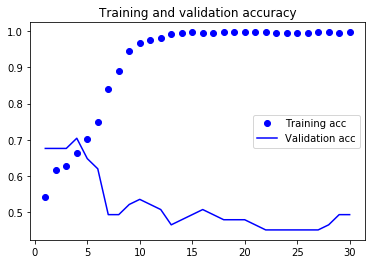

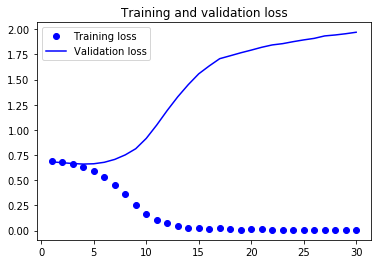

In [91]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [326]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

/Users/apple/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4393622166024848

In [327]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

/Users/apple/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.4393622166024848

In [328]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

0.5157180055768339

In [329]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

0.4393622166024848

In [330]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

/Users/apple/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.4393622166024848

In [331]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

0.4393622166024848

In [332]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

/Users/apple/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.5361099295297119

In [333]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

0.5115420825536313

In [334]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest
eval_val = root_mean_squared_log_error(Y_test, Y_pred) 
eval_val

0.5157180055768339

In [316]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,100.00
8,Decision Tree,100.00
1,KNN,76.06
0,Support Vector Machines,67.61
2,Logistic Regression,67.61
5,Perceptron,67.61
6,Stochastic Gradient Decent,67.61
7,Linear SVC,67.61
4,Naive Bayes,53.52


In [ ]:
import logging
from gensim.models import word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
sentences = word2vec.Text8Corpus('Util/jawiki_wakati.txt')
model = word2vec.Word2Vec(sentences, size=100, min_count=1, window=15)
model.save("Util/" + datetime.now().strftime("%Y%m%d%H%M%S") + "wiki.model")

2018-11-20 15:28:26,352 : INFO : collecting all words and their counts
2018-11-20 15:28:26,376 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-20 15:29:58,697 : INFO : PROGRESS: at sentence #10000, processed 100000000 words, keeping 37869465 word types
2018-11-20 15:30:19,911 : INFO : collected 44586799 word types from a corpus of 121045863 raw words and 12105 sentences
2018-11-20 15:30:19,915 : INFO : Loading a fresh vocabulary
2018-11-20 15:34:40,576 : INFO : effective_min_count=1 retains 44586799 unique words (100% of original 44586799, drops 0)
2018-11-20 15:34:40,607 : INFO : effective_min_count=1 leaves 121045863 word corpus (100% of original 121045863, drops 0)
2018-11-20 15:38:28,252 : INFO : deleting the raw counts dictionary of 44586799 items
2018-11-20 15:38:56,899 : INFO : sample=0.001 downsamples 14 most-common words
2018-11-20 15:38:56,921 : INFO : downsampling leaves estimated 100556564 word corpus (83.1% of prior 121045863)
2018-11-20 

2018-11-20 16:02:39,555 : INFO : EPOCH 1 - PROGRESS: at 3.21% examples, 41037 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:02:40,634 : INFO : EPOCH 1 - PROGRESS: at 3.26% examples, 41147 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:02:41,783 : INFO : EPOCH 1 - PROGRESS: at 3.31% examples, 41129 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:02:42,829 : INFO : EPOCH 1 - PROGRESS: at 3.36% examples, 41182 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:02:43,942 : INFO : EPOCH 1 - PROGRESS: at 3.39% examples, 40905 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:02:45,125 : INFO : EPOCH 1 - PROGRESS: at 3.42% examples, 40694 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:02:46,269 : INFO : EPOCH 1 - PROGRESS: at 3.45% examples, 40515 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:02:47,333 : INFO : EPOCH 1 - PROGRESS: at 3.49% examples, 40377 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:02:48,620 : INFO : EPOCH 1 - PROGRESS: at 3.52% examples, 40150 words/s, in_qsize 6, out_qsize 0
2

2018-11-20 16:05:03,914 : INFO : EPOCH 1 - PROGRESS: at 4.62% examples, 20134 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:05:07,612 : INFO : EPOCH 1 - PROGRESS: at 4.63% examples, 19835 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:05:11,975 : INFO : EPOCH 1 - PROGRESS: at 4.63% examples, 19486 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:05:13,191 : INFO : EPOCH 1 - PROGRESS: at 4.64% examples, 19415 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:05:16,152 : INFO : EPOCH 1 - PROGRESS: at 4.65% examples, 19198 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:05:22,458 : INFO : EPOCH 1 - PROGRESS: at 4.66% examples, 18720 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:05:23,613 : INFO : EPOCH 1 - PROGRESS: at 4.67% examples, 18663 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:05:26,309 : INFO : EPOCH 1 - PROGRESS: at 4.68% examples, 18486 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:05:30,289 : INFO : EPOCH 1 - PROGRESS: at 4.68% examples, 18216 words/s, in_qsize 5, out_qsize 0
2

2018-11-20 16:10:47,012 : INFO : EPOCH 1 - PROGRESS: at 5.34% examples, 9047 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:10:57,090 : INFO : EPOCH 1 - PROGRESS: at 5.35% examples, 8901 words/s, in_qsize 5, out_qsize 1
2018-11-20 16:11:01,043 : INFO : EPOCH 1 - PROGRESS: at 5.37% examples, 8867 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:11:13,274 : INFO : EPOCH 1 - PROGRESS: at 5.38% examples, 8697 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:11:14,562 : INFO : EPOCH 1 - PROGRESS: at 5.39% examples, 8692 words/s, in_qsize 4, out_qsize 1
2018-11-20 16:11:28,219 : INFO : EPOCH 1 - PROGRESS: at 5.40% examples, 8522 words/s, in_qsize 5, out_qsize 1
2018-11-20 16:11:29,347 : INFO : EPOCH 1 - PROGRESS: at 5.41% examples, 8519 words/s, in_qsize 4, out_qsize 1
2018-11-20 16:11:41,387 : INFO : EPOCH 1 - PROGRESS: at 5.43% examples, 8378 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:11:43,957 : INFO : EPOCH 1 - PROGRESS: at 5.44% examples, 8356 words/s, in_qsize 5, out_qsize 0
2018-11-20

2018-11-20 16:19:12,801 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 5463 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:19:15,398 : INFO : EPOCH 1 - PROGRESS: at 6.14% examples, 5465 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:19:33,038 : INFO : EPOCH 1 - PROGRESS: at 6.15% examples, 5384 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:19:49,992 : INFO : EPOCH 1 - PROGRESS: at 6.17% examples, 5323 words/s, in_qsize 4, out_qsize 1
2018-11-20 16:19:52,634 : INFO : EPOCH 1 - PROGRESS: at 6.19% examples, 5324 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:20:06,113 : INFO : EPOCH 1 - PROGRESS: at 6.20% examples, 5267 words/s, in_qsize 6, out_qsize 0
2018-11-20 16:20:08,503 : INFO : EPOCH 1 - PROGRESS: at 6.20% examples, 5262 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:20:13,334 : INFO : EPOCH 1 - PROGRESS: at 6.21% examples, 5247 words/s, in_qsize 5, out_qsize 0
2018-11-20 16:20:28,097 : INFO : EPOCH 1 - PROGRESS: at 6.22% examples, 5186 words/s, in_qsize 6, out_qsize 0
2018-11-20

In [7]:
from gensim.models import word2vec

model = word2vec.Word2Vec.load("Util/word2vec.gensim.model")
results = model.wv.most_similar(positive=['である'])
for result in results:
    print(result)

('ある', 0.7372819185256958)
('当てはまる', 0.714497447013855)
('あてはまる', 0.6894434094429016)
('成り立つ', 0.6864159107208252)
('有る', 0.6478556394577026)
('等しい', 0.6273118853569031)
('みなせる', 0.626924991607666)
('あたる', 0.6089791655540466)
('大きい', 0.5976715087890625)
('定まる', 0.5887224078178406)


In [82]:
def aeded():
    basis = "これらは"
    analyzer = CaboChaAnalyzer()
    basis_tree = analyzer.parse(re.sub("、", "",basis))
    if basis_tree.chunk_size < 2 or re.search(r'www|html|http|jpg|png|jpeg', basis) or re.search(r'www|html|http|jpg|png|jpeg', basis):
        print("success",basis)
    for chunk in basis_tree:
        for token in chunk:
            if token.pos == "名詞" and token.pos1  == "代名詞":
                return True
            elif token.pos == "連体詞" and re.match(r'こ|そ|あ|ど', token.surface):
                return True
    chunk = basis_tree[basis_tree.chunk_size - 1] if basis_tree.chunk_size > 0 else basis_tree[0]
    # if all([chunk[chunk.token_size - 1].pos != str(basis_list[causal.causalId]), str(basis_list[causal.causalId]) != None]):
    #     causals.remove(causal)
    return False

print(aeded())

success これらは
True
